In [2]:
import ipdb
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pylab as pylab
import cartopy
import cartopy.crs as ccrs
from utils import constants as cnst
from eod import msg
from utils import u_grid, u_interpolate as u_int, u_darrays as uda, u_met
import glob
import metpy
from metpy import calc
from metpy.units import units
from scipy import stats
import metpy
from metpy import calc
from metpy.units import units
import pickle as pkl
import matplotlib.patches as patches
pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [3]:
regions = {
'equatorial' : [(-5,0)],
'transition' : [(-8,-5)],
'central' : [(-12,-8)],
'southern' : [(-18,-15)]}
h = 2000

In [4]:
topo_full = xr.open_dataset('/media/ck/Elements/SouthAmerica/ERA5/hourly/ERA5_static_hourly_0.25deg_peru.nc')
topo_full = uda.flip_lat(topo_full)

In [5]:
height = xr.open_dataset('/media/ck/Elements/SouthAmerica/ERA5/hourly/topo_ERA5_peru.nc')['h']


In [6]:
def read(region, mask=True):
    
    alls = regions[region]
    hei = height.sel(latitude=slice(alls[0][0], alls[0][1])).mean('latitude').squeeze()
    topo = topo_full['z'].sel(latitude=slice(alls[0][0], alls[0][1])).mean('latitude').squeeze()
    inpath = '/media/ck/Elements/SouthAmerica/ERA5/hourly/'+region+'_cross_15UTC_1985-2018_peru_v2.nc'
    
    ds = xr.open_dataset(inpath)
    if mask:
        ds_filtered = ds.where(ds['z']>topo)
    else:
        ds_filtered = ds
    return ds_filtered

In [7]:
def calc_from_era(ds):
    pdub = np.array([list(ds.level.values),]*len(ds.longitude)).T
    p = units.Quantity(pdub, 'hPa')
    #print(p)
    t = units.Quantity(ds['t'].values, 'K')
    q = units.Quantity(ds['q'].values, 'kg/kg')
    dew = calc.dewpoint_from_specific_humidity(q, t, p)
    #ipdb.set_trace()
    theta_es = np.array(calc.saturation_equivalent_potential_temperature(p,t))#-273.15
    theta_e = np.array(calc.equivalent_potential_temperature(p,t,dew))#-273.15
    theta = np.array(calc.potential_temperature(p,t))
    theta_e_mine = u_met.theta_e(ds.level.values, ds['t'].values-273.15, ds['q'].values)+273.15
    
    tes = ds['q'].copy(deep=True)
    te = ds['q'].copy(deep=True)
    tem = ds['q'].copy(deep=True)
    th = ds['q'].copy(deep=True)
    
    tes.values = theta_es
    te.values = theta_e
    tem.values = theta_e_mine
    th.values = theta
    ds['theta_es'] = tes
    ds['theta_e'] = te
    ds['theta_em'] = tem
    ds['theta'] = th

    return ds#theta_es, theta_e, theta_e_mine

In [8]:
def apply_drywet(ds, region, spell=3, minus='0days', plus='0days', area=0.2):
    dwspells = pkl.load(open("/home/ck/DIR/cornkle/data/HUARAZ/saves/"+region+"_dw_spellDates_"+str(area)+"perc_v2.p", "rb"))
    #dwspells = pkl.load(open("/home/ck/DIR/cornkle/data/HUARAZ/saves/"+region+"_dw_spellDates_"+str(area)+"perc_3-4_5-6_7-8_StartOfSpell.p", "rb"))
    #dwspells = pkl.load(open("/home/ck/DIR/cornkle/data/HUARAZ/saves/"+region+"_dw_spellDates_"+str(area)+"perc_v2_perPix_split.p", "rb"))  #for crosssection
    dds = dwspells['dry'+str(spell)] -pd.Timedelta(minus) + pd.Timedelta(plus)
    wds = dwspells['wet'+str(spell)] -pd.Timedelta(minus) + pd.Timedelta(plus)
    
    print('dry', len(dds), 'wet', len(wds))
    xy, x_ind, y_ind  = np.intersect1d(dds, ds.time, return_indices=True)
    dds = dds[x_ind]
    
    xy, x_ind, y_ind  = np.intersect1d(wds, ds.time, return_indices=True)
    wds = wds[x_ind]
    print('dry2', len(dds), 'wet2', len(wds))

    mean_dry = ds.sel(time=dds).mean('time')
    mean_wet = ds.sel(time=wds).mean('time')
    all_dry = ds.sel(time=dds)
    all_wet = ds.sel(time=wds)
    
#     ## clims
#     doy_dryclim = ds.groupby('time.dayofyear').mean('time').sel(dayofyear=np.unique(dds.dayofyear)).mean('dayofyear')
#     doy_wetclim = ds.groupby('time.dayofyear').mean('time').sel(dayofyear=np.unique(wds.dayofyear)).mean('dayofyear')
    
#     doy_dryclim = ds.groupby('time.dayofyear').mean('time').sel(dayofyear=np.unique(dds.dayofyear)).mean('dayofyear')
#     doy_wetclim = ds.groupby('time.dayofyear').mean('time').sel(dayofyear=np.unique(wds.dayofyear)).mean('dayofyear')
    
#     xyd, x_indd, y_indd = np.intersect1d(ds['time.dayofyear'].values,dds.dayofyear.values, return_indices=True)
#     xyw, x_indw, y_indw = np.intersect1d(ds['time.dayofyear'].values,wds.dayofyear.values, return_indices=True)
    
#     #ipdb.set_trace()
#     wdays = []
#     for dst in ds.time:
#         if dst['time.dayofyear'].values in wds.dayofyear.values:
#             wdays.append(dst.time.values)
#     ddays = []
#     for dst in ds.time:
#         if dst['time.dayofyear'].values in dds.dayofyear.values:
#             ddays.append(dst.time.values)
#     #ipdb.set_trace()
#     doy_dryclim_all = ds.sel(time=ddays)
#     doy_wetclim_all = ds.sel(time=wdays)
#     #
#     mean_clim = ds.mean('time')

    doy_dryclim_all = ds.sel(time=ds['time.dayofyear'].isin(dds.dayofyear))
    doy_wetclim_all = ds.sel(time=ds['time.dayofyear'].isin(wds.dayofyear))
    
    doy_dryclim = doy_dryclim_all.mean('time')
    doy_wetclim = doy_dryclim_all.mean('time')
    
    mean_clim = ds.mean('time')
    
    
    for dat in [mean_dry, mean_wet, doy_dryclim, doy_wetclim, mean_clim]:
        dat = calc_from_era(dat)
    
    
    outdic = {'dry' : mean_dry,
              'wet' : mean_wet,
              'dry_ttest' : all_dry,
              'wet_ttest' : all_wet,
              'dry_doyclim' : doy_dryclim,
              'wet_doyclim' : doy_wetclim,
              'mean_clim' : mean_clim,
              'all_clim' : ds,
              'dry_doyclim_ttest' : doy_dryclim_all,
              'wet_doyclim_ttest' : doy_wetclim_all}
    
    return outdic

In [12]:
ar = 0.15
spelldays = 7

In [13]:
reg_tag = 'transition'
ds_filtered = read(reg_tag)

In [14]:
ds_filtered

<xarray.Dataset>
Dimensions:    (level: 17, longitude: 101, time: 9696)
Coordinates:
  * longitude  (longitude) float32 -82.0 -81.75 -81.5 ... -57.5 -57.25 -57.0
  * level      (level) int32 200 300 400 500 550 600 ... 850 875 900 925 950 975
  * time       (time) datetime64[ns] 1986-03-23 1986-11-18 ... 2018-06-05
Data variables:
    d          (time, level, longitude) float32 -5.860213e-07 ... -6.523573e-06
    z          (time, level, longitude) float32 121893.8 121900.26 ... 3387.8594
    r          (time, level, longitude) float32 49.551144 ... 57.328964
    q          (time, level, longitude) float32 3.8741156e-05 ... 0.01393883
    t          (time, level, longitude) float32 219.60847 ... 301.13483
    u          (time, level, longitude) float32 -10.796594 ... -1.4777732
    v          (time, level, longitude) float32 -5.868569 ... 1.2337651
    w          (time, level, longitude) float32 0.0073632738 ... -0.0005879402

In [15]:
transition_dic = apply_drywet(ds_filtered, reg_tag, spell=spelldays, minus='0days', plus='0days', area=ar)
transition_dic_n1 = apply_drywet(ds_filtered, reg_tag, spell=spelldays, minus='1days', plus='0days', area=ar)

dry 497 wet 144
dry2 494 wet2 144
dry 497 wet 144
dry2 493 wet2 144


In [16]:
reg_tag = 'equatorial'
ds_filtered = read(reg_tag)

In [17]:
equatorial_dic = apply_drywet(ds_filtered, reg_tag, spell=spelldays, minus='0days', plus='0days', area=ar)
equatorial_dic_n1 = apply_drywet(ds_filtered, reg_tag, spell=spelldays, minus='1days', plus='0days', area=ar)

dry 495 wet 132
dry2 489 wet2 132
dry 495 wet 132
dry2 489 wet2 132


In [18]:
reg_tag = 'central'
ds_filtered = read(reg_tag)

In [19]:
central_dic = apply_drywet(ds_filtered, reg_tag, spell=spelldays, minus='0days', plus='0days', area=ar)
central_dic_n1 = apply_drywet(ds_filtered, reg_tag, spell=spelldays, minus='1days', plus='0days', area=ar)

dry 198 wet 169
dry2 187 wet2 168
dry 198 wet 169
dry2 186 wet2 169


In [20]:
reg_tag = 'southern'
ds_filtered = read(reg_tag)

In [21]:
southern_dic = apply_drywet(ds_filtered, reg_tag, spell=spelldays, minus='0days', plus='0days', area=ar)
southern_dic_n1 = apply_drywet(ds_filtered, reg_tag, spell=spelldays, minus='1days', plus='0days', area=ar)

dry 87 wet 52
dry2 80 wet2 51
dry 87 wet 52
dry2 79 wet2 50


In [22]:
sospell = pkl.load(open("/home/ck/DIR/cornkle/data/HUARAZ/saves/southern_dw_spellDates_0.15perc_v2.p", "rb"))

In [23]:
mcs = xr.open_mfdataset('/media/ck/Elements/SouthAmerica/CHIRPS/SA_daily_onERA/CHIRPS_daily_onERA_*.nc')

In [24]:
#tir = mcs['tir'].sel(time=((mcs['time.year']>=1985)&(mcs['time.year']<=2018))).sel(latitude=slice(-25,0), longitude=slice(-81,-58)).load()
tir = mcs['precip'].sel(time=((mcs['time.year']>=1985)&(mcs['time.year']<=2018))).sel(latitude=slice(-25,0), longitude=slice(-81,-58)).load()

In [25]:
def draw_cross(ax, data, lon, lat, title=None, xlabel=None, ylabel=None,  cmap=None,mask_sig=None, quiver=None, contour=None, cbar_label=None, twinx=None, cbar=None,**kwargs):

    mapp = ax.contourf(lon, lat, data, extend='both', cmap=cmap, **kwargs)  # this is the actual plot   # alpha=0.8,
 #   ax.set_facecolor('lightgrey')
    
#     cmapp = uplot.discrete_cmap(25, base_cmap=cmap)
#     mapp = ax.pcolormesh(lon, lat,data,cmap=cmapp, vmin=50, vmax=68)
    ax.set_ylim(170,1000)
    
    #ax.set_xlim(-81.5,-60)
    # Adjust the y-axis to be logarithmic
    #ax.set_yscale('symlog')
    #ax.set_yticklabels(np.arange(1000, 50, -1000)
    
    #ax.set_yticks(np.arange(1000, 50, -100))
    plt.gca().invert_yaxis()
    if mask_sig is not None:
         plt.contourf(lon, lat, mask_sig, colors='none', hatches='.',
                     levels=[0.5, 1], linewidth=0.1)
    
    if quiver is not None:
        
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'], scale=quiver['scale'], width=0.0025, headwidth=8, color='k')
#         qk = plt.quiverkey(qu, 0.45, 0.52, 1, '1 m s$^{-1}$ | ',
#                            labelpos='E', coordinates='figure')
        
    if contour is not None:
        cs = ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], colors=contour['colours'], linewidths=0.5 )
        plt.clabel(cs, inline=1, fontsize=8, fmt='%1.1f')  #, fmt='%1.1f'
        
    if twinx is not None:
        ax1 = ax.twinx()
        ax1.plot(twinx['x'], twinx['y'], twinx['color'] )
        ax1.set_ylabel(twinx['ylabel'])
        ax1.set_ylim(twinx['ylim'][0], twinx['ylim'][1])
    
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    if cbar:
        cbar = plt.colorbar(mapp, pad=0.01, format='%1.1f')  # adds colorbar '%d'
        #cbar = plt.colorbar(mapp, ticks=np.linspace(50,68,25), pad=0.09)
        cbar.set_label(cbar_label)
    
    return mapp

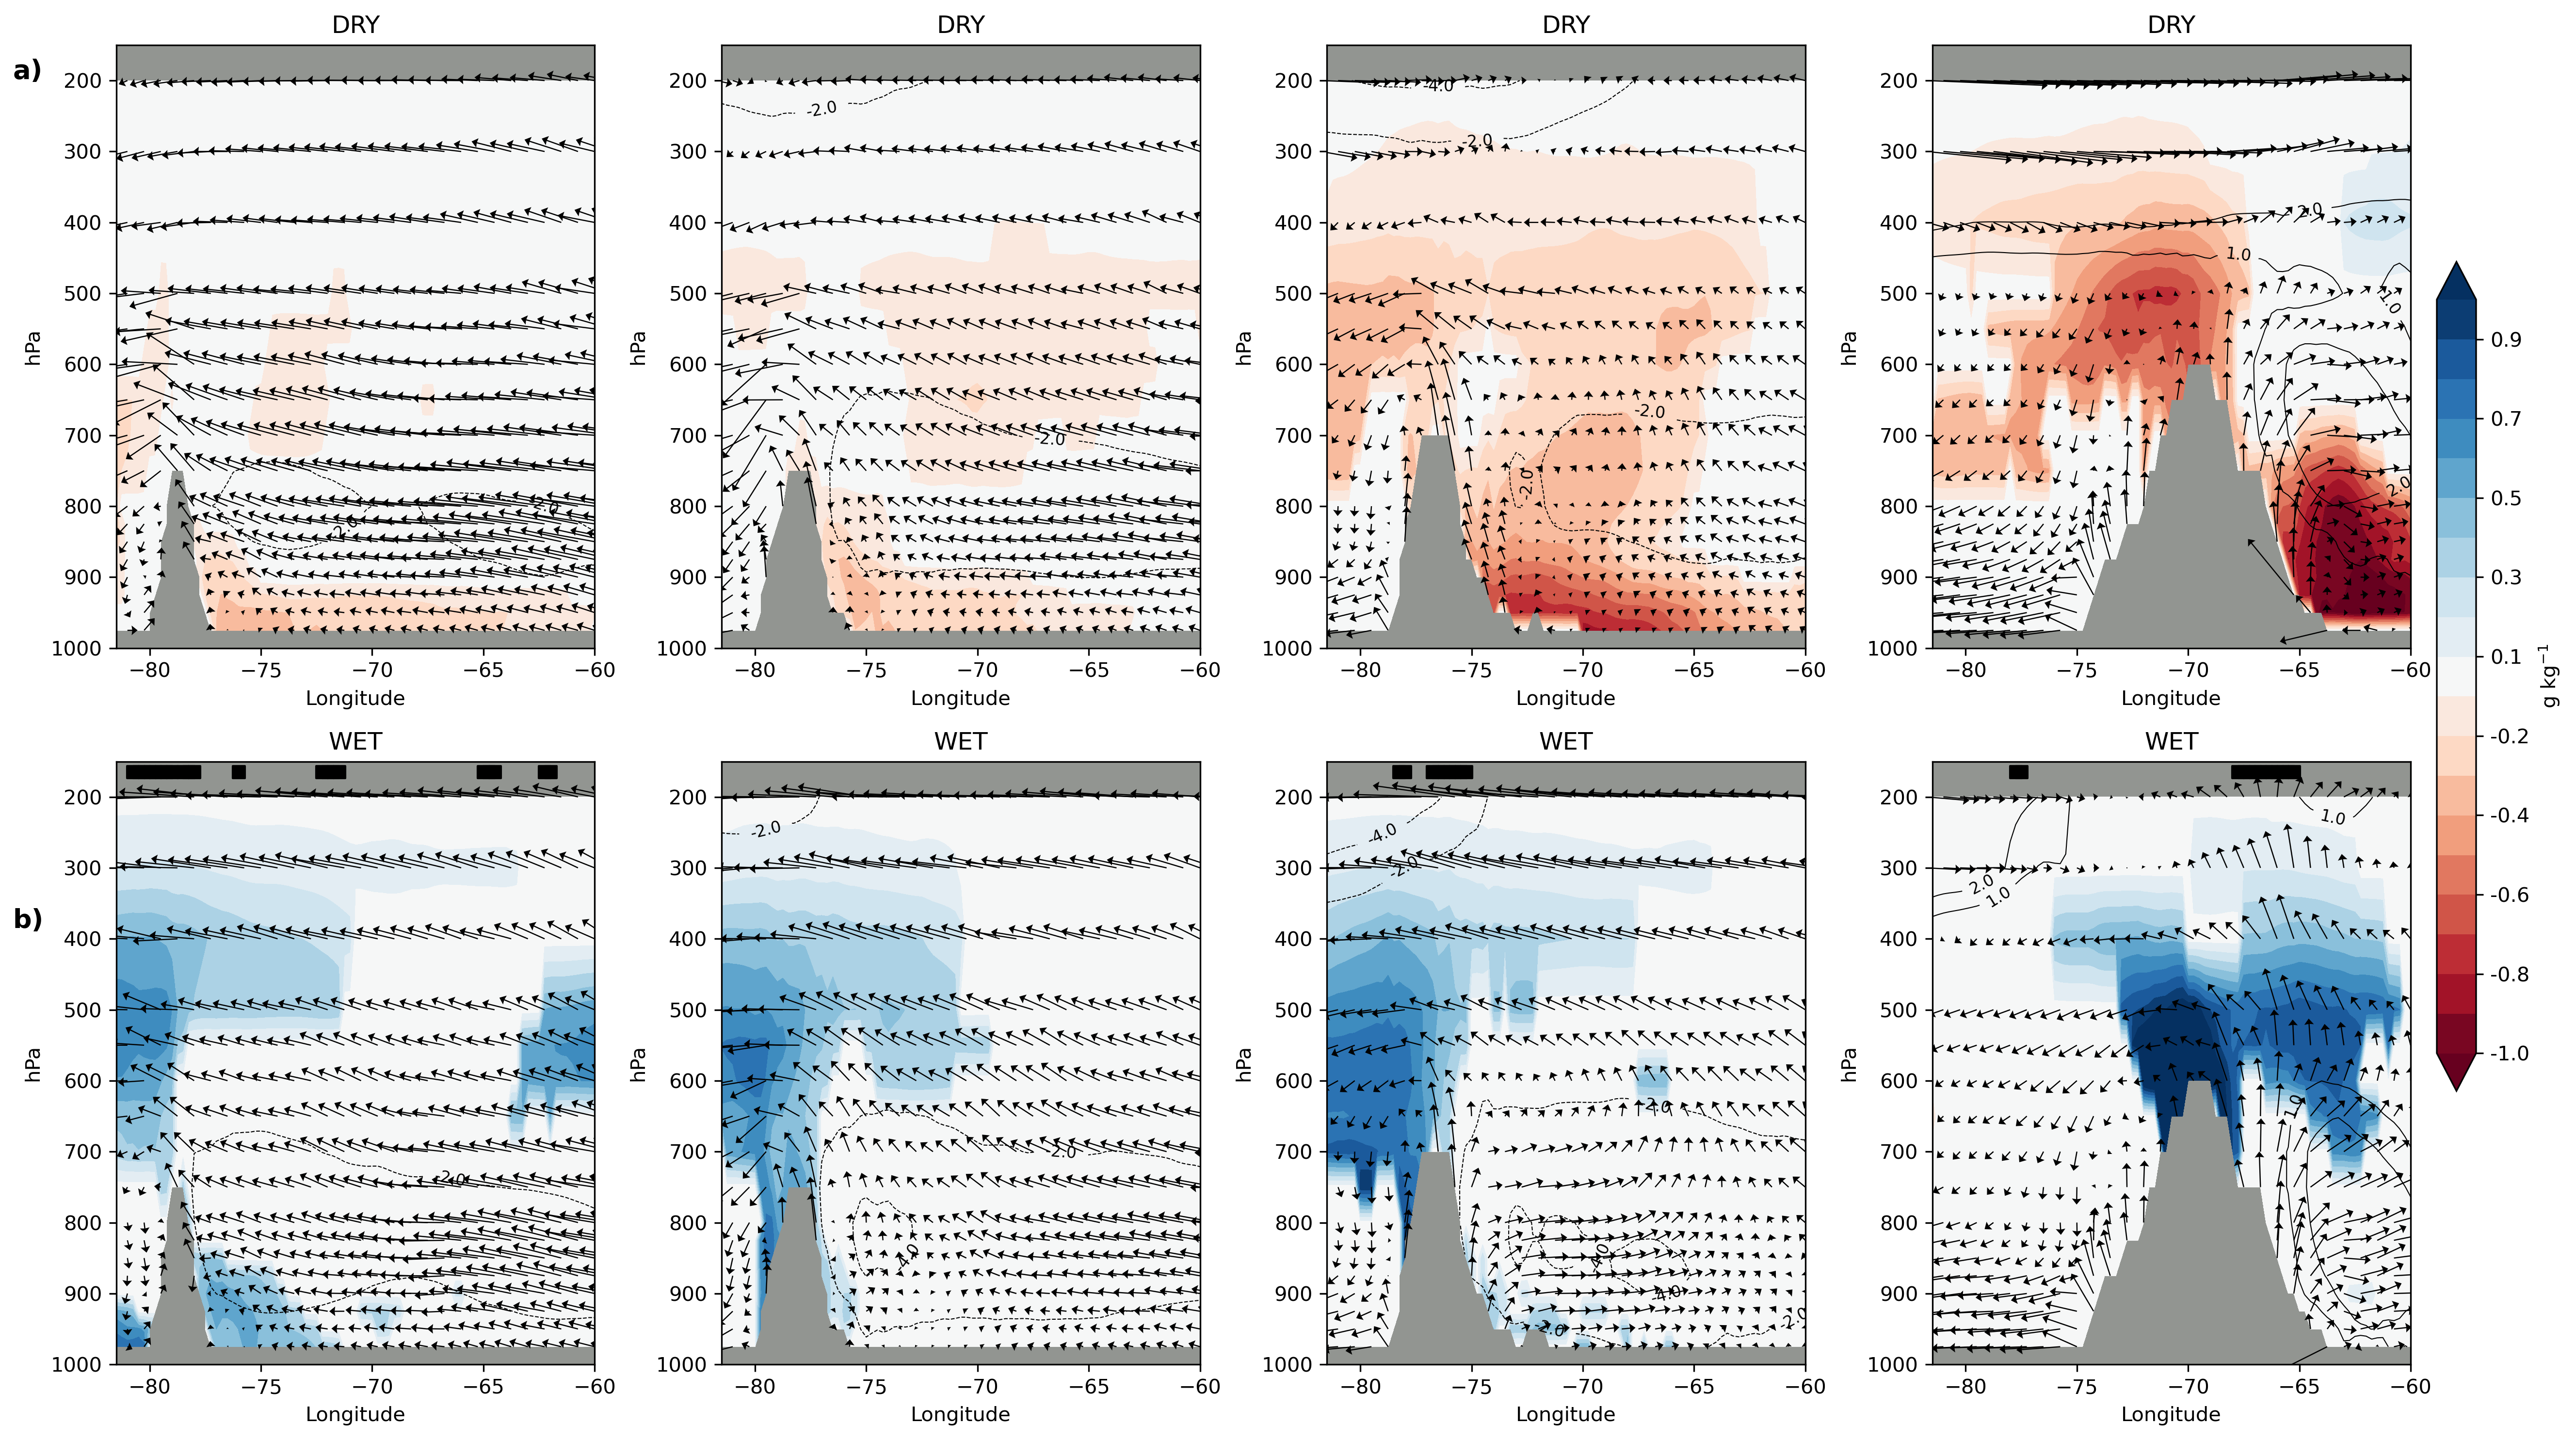

In [31]:
ml = 0.5
lonsample=[(-78.25+ml, -73.75), (-77.25+ml, -72.75), (-75.5+ml, -71.0), (-66.25+ml, -61.75)]


#allclim
# slices_months = [ ('3d equatorial DRY', equatorial_dic['wet'], equatorial_dic['wet_ttest'],equatorial_dic['mean_clim'], equatorial_dic['all_clim']),
#                   ('3d transition DRY', transition_dic['wet'], transition_dic['wet_ttest'],transition_dic['mean_clim'], transition_dic['all_clim']),
#                  ('3d central DRY', central_dic['wet'], central_dic['wet_ttest'],central_dic['mean_clim'], central_dic['all_clim']),   #dry_clim_allc.mean('time')
#                  ('3w southern DRY',southern_dic['wet'], southern_dic['wet_ttest'],southern_dic['mean_clim'], southern_dic['all_clim']) ]  # mean_wet3, all_wet3, doy_wetclim3, wet_clim_all) ]

# slices_months_d = [ ('3d equatorial DRY', equatorial_dic['dry'], equatorial_dic['dry_ttest'],equatorial_dic['mean_clim'], equatorial_dic['all_clim']),
#                   ('3d transition DRY', transition_dic['dry'], transition_dic['dry_ttest'],transition_dic['mean_clim'], transition_dic['all_clim']),
#                  ('3d central DRY', central_dic['dry'], central_dic['dry_ttest'],central_dic['mean_clim'], central_dic['all_clim']),   #dry_clim_allc.mean('time')
#                  ('3w southern DRY',southern_dic['dry'], southern_dic['dry_ttest'],southern_dic['mean_clim'], southern_dic['all_clim']) ]  

### doyclim
slices_months_d = [ ('3d equatorial DRY', equatorial_dic['dry'], equatorial_dic['dry_ttest'],equatorial_dic['dry_doyclim'], equatorial_dic['dry_doyclim_ttest']),
                  ('3d transition DRY', transition_dic['dry'], transition_dic['dry_ttest'],transition_dic['dry_doyclim'], transition_dic['dry_doyclim_ttest']),
                 ('3d central DRY', central_dic['dry'], central_dic['dry_ttest'],central_dic['dry_doyclim'], central_dic['dry_doyclim_ttest']),   #dry_clim_allc.mean('time')
                 ('3w southern DRY',southern_dic['dry'], southern_dic['dry_ttest'],southern_dic['dry_doyclim'], southern_dic['dry_doyclim_ttest']) ]  # mean_wet3, all_wet3, doy_wetclim3, wet_clim_all) ]

slices_months = [ ('3d equatorial DRY', equatorial_dic['wet'], equatorial_dic['wet_ttest'],equatorial_dic['wet_doyclim'], equatorial_dic['wet_doyclim_ttest']),
                  ('3d transition DRY', transition_dic['wet'], transition_dic['wet_ttest'],transition_dic['wet_doyclim'], transition_dic['wet_doyclim_ttest']),
                 ('3d central DRY', central_dic['wet'], central_dic['wet_ttest'],central_dic['wet_doyclim'], central_dic['wet_doyclim_ttest']),   #dry_clim_allc.mean('time')
                 ('3w southern DRY',southern_dic['wet'], southern_dic['wet_ttest'],southern_dic['wet_doyclim'], southern_dic['wet_doyclim_ttest']) ]  



###day-1
# slices_months_d = [ ('3d equatorial DRY', equatorial_dic_n1['dry'], equatorial_dic_n1['dry_ttest'],equatorial_dic_n1['dry_doyclim'], equatorial_dic_n1['dry_doyclim_ttest']),
#                   ('3d transition DRY', transition_dic_n1['dry'], transition_dic_n1['dry_ttest'],transition_dic_n1['dry_doyclim'], transition_dic_n1['dry_doyclim_ttest']),
#                  ('3d central DRY', central_dic_n1['dry'], central_dic_n1['dry_ttest'],central_dic_n1['dry_doyclim'], central_dic_n1['dry_doyclim_ttest']),   #dry_clim_allc.mean('time')
#                  ('3w southern DRY',southern_dic_n1['dry'], southern_dic_n1['dry_ttest'],southern_dic_n1['dry_doyclim'], southern_dic_n1['dry_doyclim_ttest']) ]  # mean_wet3, all_wet3, doy_wetclim3, wet_clim_all) ]

# slices_months = [ ('3d equatorial DRY', equatorial_dic_n1['wet'], equatorial_dic_n1['wet_ttest'],equatorial_dic_n1['wet_doyclim'], equatorial_dic_n1['wet_doyclim_ttest']),
#                   ('3d transition DRY', transition_dic_n1['wet'], transition_dic_n1['wet_ttest'],transition_dic_n1['wet_doyclim'], transition_dic_n1['wet_doyclim_ttest']),
#                  ('3d central DRY', central_dic_n1['wet'], central_dic_n1['wet_ttest'],central_dic_n1['wet_doyclim'], central_dic_n1['wet_doyclim_ttest']),   #dry_clim_allc.mean('time')
#                  ('3w southern DRY',southern_dic_n1['wet'], southern_dic_n1['wet_ttest'],southern_dic_n1['wet_doyclim'], southern_dic_n1['wet_doyclim_ttest']) ]  






f = plt.figure(figsize=(18,10), dpi=300)
for ids in range(8):
    
            
    ax = f.add_subplot(2,4,ids+1)
    
    if ids in [0,1,2,3]:
        
        cnt=ids
        tit = 'DRY'
        dd = slices_months_d[cnt]
    else:
        cnt = ids-4
        dd = slices_months[cnt]
        tit = 'WET'

    slices = dd[1] # d/w mean
    tag = dd[0]

    slices_ttest = dd[2] #  d/w all, for day-wise t-test, all days versus only wet/dry
    slice_clim = dd[3] # doy d/w clim
    clim_ttest = dd[4]

    # "current zonal wind" wind vectors
    vano = slices['u']
    wano = slices['w']*(-20)  # multiplied by 10 since vertical component is very small compared to horizontal one
    vclim = slice_clim['u']
    wclim = slice_clim['w']*(-20)
    st=2
    stt = 3
    sarrow = 1
    xquiv = slices.longitude[sarrow::stt]
    yquiv = slices.level

    uu = (vano)#[::, sarrow::stt]  
    ww = (wano)#[::, sarrow::stt]
    uuc = (vclim)#[::, sarrow::stt]  
    wwc = (wclim)#[::, sarrow::stt] 
    utstat, upval = stats.ttest_ind(slices_ttest['u'], clim_ttest['u'], axis=0, equal_var=False)
    umask = upval<=0.05

    wtstat, wpval = stats.ttest_ind(slices_ttest['w'], clim_ttest['w'], axis=0, equal_var=False)

    wmask = wpval<=0.05
    if ids in [5,7]:
        wmask = wpval<=0.15

    vtstat, vpval = stats.ttest_ind(slices_ttest['v'], clim_ttest['v'], axis=0, equal_var=False)
    vmask = vpval<=0.05

    bothmask = wmask | umask#[::, sarrow::stt] #| wmask[::, sarrow::stt] 
    #ipdb.set_trace()


    uu = uu #-uuc
    ww = ww #- wwc
#     uu = uu.where(bothmask)
#     ww = ww.where(bothmask)


    uu = uu[::, sarrow::stt]
    ww = ww[::, sarrow::stt]
    
    data = slices['v']#-slice_clim['v'] #+ ((slices['v']-slice_clim['v']))
    data4 = slices['u']#-slice_clim['u']
    
    conlev = [-4,-2]
    if cnt==3:
        data = data4
        conlev = [1,2]

    qin = {'x' : xquiv, 'y' : yquiv, 'u' : uu, 'v' : ww, 'scale' : 50}

    # temperature and moisture check

    var3 = 'd'
    data3 = (slices[var3]-slice_clim[var3])*1500000 # #- slice_clim[var] - slice_clim[var]  #slices
    a3= slices_ttest[var3] 
    b3= clim_ttest[var3]
    tstat3, pval3= stats.ttest_ind(a3, b3, axis=0)
    mask3= pval3<=0.05

    data3.values[(~mask3)] = 0

    dpos = np.where((data3.values[0,:])>5)



    var = 'q'
    var2 = 'q'
    data2 = (slices[var]-slice_clim[var])*1000#-slice_clim[var])
    a = slices_ttest[var2] 
    b = clim_ttest[var2]
    tstat, pval = stats.ttest_ind(a, b, axis=0)
    mask = pval<=0.05
    data2.values[(~mask) & (np.isfinite(data2.values)) ] = 0 # & (np.isfinite(data2.values)

    contour = {'data' : data, 'x' :slices.longitude, 'y' : slices.level, 'levels' : conlev, 'colours' : 'k'}  #np.arange(335,355, 1)
    xlab = 'Longitude'


    mapp = draw_cross(ax, data2, slices.longitude, slices.level, ylabel = 'hPa', xlabel=xlab,cmap='RdBu', quiver=qin, contour=contour,levels=np.linspace(-1,1,20) ,cbar=False, cbar_label='g kg$^{-1}') #np.arange(-2, 2.1, 0.25)  #Spectral g kg$^{-1} m s$^{-1}$
 
    ax.scatter(slices.longitude[dpos[0]], [165]*len(dpos[0]), color='k', marker='s')
#     ax.axvline(lon1, color='k', linewidth=0.5)
#     ax.axvline(lon2, color='k', linewidth=0.5)
    #ax.scatter(slices.longitude[eastpos[0]], [200]*len(eastpos[0]), color='red', marker='s')
    ax.set_facecolor('xkcd:grey') #xkcd:grey
    ax.set_ylim(1000, 150)
    ax.set_xlim(-81.5, -60)

    ax.set_title(tit)
        

plt.subplots_adjust(wspace=0.11, hspace=0.15)   
plt.tight_layout()

f.subplots_adjust(right=0.92)
cax = f.add_axes([0.93,0.245,0.015,0.57])
cbar = f.colorbar(mapp, cax, format='%1.1f',label=r'g kg$^{-1}$')

plt.annotate('a)', xy=(0.005, 0.94), xytext=(0, 4), size=13, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points', fontweight='bold')
plt.annotate('b)', xy=(0.005, 0.35), xytext=(0, 4), size=13, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points', fontweight='bold')

f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/paper/drywet_cross_map_horizontal_WETDRY_supplem_7d_q_doyclim_windraw.jpg')